In [1]:
import pickle
from string import punctuation

import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# Load the data
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

import dask.bag as db
import json

docs = db.read_text('../Data/arxiv-metadata-oai-snapshot.json').map(json.loads)

In [3]:
docs.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

In [4]:
# Trimming the data
get_latest_version = lambda x: x['versions'][-1]['created']


# get only necessary fields of the metadata file
trim = lambda x: {'id': x['id'],
                  'authors': x['authors'],
                  'title': x['title'],
                  'doi': x['doi'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract'],}

# filter for papers published on or after 2019-01-01
columns = ['id','category','abstract']
docs_df = (docs.filter(lambda x: int(get_latest_version(x).split(' ')[3]) > 2019)
           .map(trim).
           compute())

# convert to pandas
docs_df = pd.DataFrame(docs_df)

In [5]:
#save trimmed dataset for later use so we can skip the dataset trimming later:
docs_df.to_csv("../Data/trimmed_arxiv_docs.csv", index=False)

In [3]:
# Read docs from the file
docs_df = pd.read_csv('../Data/trimmed_arxiv_docs.csv')

/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
#The first 5 rows:
docs_df.head()

,id,authors,title,doi,category,abstract
0,704.0479,T.Geisser,The affine part of the Picard scheme,NaN,"['math.AG', 'math.KT']",We describe the maximal torus and maximal un...
1,705.0825,Ram Gopal Vishwakarma (Zacatecas University),Einstein's Theory of Gravity in the Presence o...,10.1007/s10509-009-0016-8,"['gr-qc', 'astro-ph', 'hep-th']",The mysterious `dark energy' needed to expla...
2,705.4004,Samy Skander Bahoura (IMJ),About Brezis-Merle Problem with Lipschitz cond...,NaN,['math.AP'],We give blow-up analysis for a Brezis-Merle'...
3,705.406,Ruy Exel and Artur O. Lopes,C*- Algebras and Thermodynamic Formalism,NaN,"['math.DS', 'math.OA']",We present a detailed exposition (for a Dyna...
4,705.4151,"Maria Deijfen, Henri van den Esker, Remco van ...",A preferential attachment model with random in...,10.1007/s11512-007-0067-4,"['math.PR', 'math.CO']","In this paper, a random graph process ${G(t)..."


In [5]:
# Listing categories
categories = list(docs_df['category'].unique())
for i in categories:
    print(i)
        

['math.AG', 'math.KT']
['gr-qc', 'astro-ph', 'hep-th']
['math.AP']
['math.DS', 'math.OA']
['math.PR', 'math.CO']
['math.AC', 'math.AG']
['math.AG']
['quant-ph']
['math.QA', 'math.RA']
['math.NT', 'math.AG']
['math.GT', 'math.GR']
['hep-ph']
['physics.gen-ph']
['math.RT', 'math.CO']
['hep-th', 'cond-mat.other']
['math.AC']
['cond-mat.mes-hall', 'nlin.CD']
['math.DS']
['math.AT', 'math.GR']
['math.AG', 'math.NT']
['math.CO']
['astro-ph']
['math.HO']
['physics.class-ph']
['math.NT', 'math.CO']
['cond-mat.supr-con', 'cond-mat.mes-hall']
['math.NT']
['physics.optics', 'physics.gen-ph']
['math.LO']
['math.CO', 'cs.DM', 'math.GM']
['math.RT', 'math.AG']
['gr-qc']
['math.KT']
['math.NT', 'math.OA']
['math.DS', 'math.HO']
['cs.OH']
['math.DG']
['quant-ph', 'cs.CR']
['math.GT']
['math.GM']
['cond-mat.other', 'hep-lat', 'hep-th', 'quant-ph']
['math.RT']
['math.PR', 'math.ST', 'stat.TH']
['q-bio.BM']
['physics.ao-ph', 'math.AP', 'nlin.PS', 'nlin.SI', 'physics.comp-ph', 'physics.geo-ph']
['cs.CC']


In [6]:
# Split categories
def splitCategory(cat):
    tmp = cat.replace('[','').replace(']','')
    c = tmp.split(', ')
    c = [w.replace("'","") for w in c]
    return c

In [7]:
# Find main category
def findMainCat(categories):
    new_cat = list(dict.fromkeys([cat.split(".")[0] for cat in categories]))
    return new_cat


Cleaning the data

In [8]:
df = pd.read_csv("../Data/trimmed_arxiv_docs.csv")

/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377629 entries, 0 to 377628
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        377629 non-null  object
 1   authors   377629 non-null  object
 2   title     377629 non-null  object
 3   doi       117502 non-null  object
 4   category  377629 non-null  object
 5   abstract  377629 non-null  object
dtypes: object(6)
memory usage: 17.3+ MB


In [10]:
# Adding abstract word count
df['abstract_word_count'] = docs_df['abstract'].apply(lambda x: len(x.strip().split())) 

In [11]:
df['abstract'].describe(include='all')

count                                                377629
unique                                               377559
top         We use the theory of normal variance-mean mi...
freq                                                      2
Name: abstract, dtype: object

In [12]:
# Getting rid of duplicates
df.drop_duplicates(['abstract',], inplace=True)
df['abstract'].describe(include='all')

count                                                377559
unique                                               377559
top         We compute the contribution of third generat...
freq                                                      1
Name: abstract, dtype: object

NLP data processing

In [13]:
# Add the categories
df['list_categories'] = df.category.apply(splitCategory)
df['main_categories'] = df.list_categories.apply(findMainCat)

In [14]:
df

,id,authors,title,doi,category,abstract,abstract_word_count,list_categories,main_categories
0,704.0479,T.Geisser,The affine part of the Picard scheme,NaN,"['math.AG', 'math.KT']",We describe the maximal torus and maximal un...,21,"[math.AG, math.KT]",[math]
1,705.0825,Ram Gopal Vishwakarma (Zacatecas University),Einstein's Theory of Gravity in the Presence o...,10.1007/s10509-009-0016-8,"['gr-qc', 'astro-ph', 'hep-th']",The mysterious `dark energy' needed to expla...,83,"[gr-qc, astro-ph, hep-th]","[gr-qc, astro-ph, hep-th]"
2,705.4004,Samy Skander Bahoura (IMJ),About Brezis-Merle Problem with Lipschitz cond...,NaN,['math.AP'],We give blow-up analysis for a Brezis-Merle'...,39,[math.AP],[math]
3,705.406,Ruy Exel and Artur O. Lopes,C*- Algebras and Thermodynamic Formalism,NaN,"['math.DS', 'math.OA']",We present a detailed exposition (for a Dyna...,110,"[math.DS, math.OA]",[math]
4,705.4151,"Maria Deijfen, Henri van den Esker, Remco van ...",A preferential attachment model with random in...,10.1007/s11512-007-0067-4,"['math.PR', 'math.CO']","In this paper, a random graph process ${G(t)...",152,"[math.PR, math.CO]",[math]
...,...,...,...,...,...,...,...,...,...
377624,quant-ph/0507088,Rahul Jain,Chain-rules for channel capacity,NaN,['quant-ph'],We show some chain-rules for the capacity of...,32,[quant-ph],[quant-ph]
377625,quant-ph/0604056,Scott Aaronson and Greg Kuperberg,Quantum Versus Classical Proofs and Advice,NaN,"['quant-ph', 'cs.CC']",This paper studies whether quantum proofs ar...,174,"[quant-ph, cs.CC]","[quant-ph, cs]"
377626,quant-ph/0612050,"Igor Devetak, Jon Yard",The exact cost of redistributing multipartite ...,10.1103/PhysRevLett.100.230501,['quant-ph'],How correlated are two quantum systems from ...,118,[quant-ph],[quant-ph]
377627,quant-ph/0701163,Daegene Song,Does Observation Create Reality?,NaN,['quant-ph'],It has been suggested that the locality of i...,112,[quant-ph],[quant-ph]


In [15]:
# Create CS and Random dataframes
bool_series = ["cs" in cat for cat in df.main_categories]
df_cs = df[bool_series]

In [16]:
df_cs

,id,authors,title,doi,category,abstract,abstract_word_count,list_categories,main_categories
30,801.3697,George I. Bell,The mathematics of Septoku,NaN,"['math.CO', 'cs.DM', 'math.GM']",Septoku is a Sudoku variant invented by Bruc...,93,"[math.CO, cs.DM, math.GM]","[math, cs]"
39,805.1293,Avik Chakraborty,Testability of Reversible Iterative Logic Arrays,NaN,['cs.OH'],Iterative Logic Arrays (ILAs) are ideal as V...,227,[cs.OH],[cs]
43,806.0557,"Qin Li, Chengqing Li, Chunhui Wu, Dongyang Lon...",An efficient and provably secure arbitrated qu...,NaN,"['quant-ph', 'cs.CR']","In this paper, an efficient arbitrated quant...",120,"[quant-ph, cs.CR]","[quant-ph, cs]"
57,809.2093,"Troy Lee, Adi Shraibman",An approximation algorithm for approximation rank,NaN,['cs.CC'],One of the strongest techniques available fo...,188,[cs.CC],[cs]
65,810.484,"Dorit Aharonov, Michael Ben-Or, Fernando G.S.L...",The Pursuit of Uniqueness: Extending Valiant-V...,NaN,"['quant-ph', 'cs.CC']",Valiant-Vazirani showed in 1985 [VV85] that ...,195,"[quant-ph, cs.CC]","[quant-ph, cs]"
...,...,...,...,...,...,...,...,...,...
377513,cs/0606037,Andrej Bogdanov and Luca Trevisan,Average-Case Complexity,NaN,['cs.CC'],We survey the average-case complexity of pro...,170,[cs.CC],[cs]
377514,cs/0608050,Pascal Pons and Matthieu Latapy,Post-Processing Hierarchical Community Structu...,10.1016/j.tcs.2010.11.041,"['cs.DS', 'cond-mat.dis-nn', 'physics.soc-ph']",Dense sub-graphs of sparse graphs (communiti...,122,"[cs.DS, cond-mat.dis-nn, physics.soc-ph]","[cs, cond-mat, physics]"
377515,cs/0610128,Daniel Lemire and Owen Kaser,Hierarchical Bin Buffering: Online Local Momen...,10.1145/1328911.1328925,"['cs.DS', 'cs.DB']","Local moments are used for local regression,...",184,"[cs.DS, cs.DB]",[cs]
377547,math/0008020,Matthieu Latapy and Thi Ha Duong Phan,The Lattice of integer partitions and its infi...,10.1016/j.disc.2008.02.002,"['math.CO', 'cs.NA', 'math.DS', 'math.NA', 'ma...","In this paper, we use a simple discrete dyna...",152,"[math.CO, cs.NA, math.DS, math.NA, math.NT]","[math, cs]"


In [17]:
# Non-CS df
bool_series = ["cs" not in cat for cat in df.main_categories]
df_random = df[bool_series]

In [18]:
df_random

,id,authors,title,doi,category,abstract,abstract_word_count,list_categories,main_categories
0,704.0479,T.Geisser,The affine part of the Picard scheme,NaN,"['math.AG', 'math.KT']",We describe the maximal torus and maximal un...,21,"[math.AG, math.KT]",[math]
1,705.0825,Ram Gopal Vishwakarma (Zacatecas University),Einstein's Theory of Gravity in the Presence o...,10.1007/s10509-009-0016-8,"['gr-qc', 'astro-ph', 'hep-th']",The mysterious `dark energy' needed to expla...,83,"[gr-qc, astro-ph, hep-th]","[gr-qc, astro-ph, hep-th]"
2,705.4004,Samy Skander Bahoura (IMJ),About Brezis-Merle Problem with Lipschitz cond...,NaN,['math.AP'],We give blow-up analysis for a Brezis-Merle'...,39,[math.AP],[math]
3,705.406,Ruy Exel and Artur O. Lopes,C*- Algebras and Thermodynamic Formalism,NaN,"['math.DS', 'math.OA']",We present a detailed exposition (for a Dyna...,110,"[math.DS, math.OA]",[math]
4,705.4151,"Maria Deijfen, Henri van den Esker, Remco van ...",A preferential attachment model with random in...,10.1007/s11512-007-0067-4,"['math.PR', 'math.CO']","In this paper, a random graph process ${G(t)...",152,"[math.PR, math.CO]",[math]
...,...,...,...,...,...,...,...,...,...
377623,quant-ph/0411039,Sofia Wechsler,What was in the apparatus before the click,NaN,['quant-ph'],When a quantum system is described by a wave...,144,[quant-ph],[quant-ph]
377624,quant-ph/0507088,Rahul Jain,Chain-rules for channel capacity,NaN,['quant-ph'],We show some chain-rules for the capacity of...,32,[quant-ph],[quant-ph]
377626,quant-ph/0612050,"Igor Devetak, Jon Yard",The exact cost of redistributing multipartite ...,10.1103/PhysRevLett.100.230501,['quant-ph'],How correlated are two quantum systems from ...,118,[quant-ph],[quant-ph]
377627,quant-ph/0701163,Daegene Song,Does Observation Create Reality?,NaN,['quant-ph'],It has been suggested that the locality of i...,112,[quant-ph],[quant-ph]


In [19]:
# Reduce the size of the data
df_cs = df_cs.sample(10000, random_state=42)
df_random = df_random.sample(10000, random_state=42)

In [20]:
#Define stopwords (scientific stopwords)
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = STOP_WORDS

In [21]:
#Define the cleaner - remove punctuation and stopwords
def cleanPunct(text):
    return [w for w in text if w not in punctuation]

In [22]:
# make everything lowercase
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
def low(instance):
    tokens = word_tokenize(instance)
    return [w.lower() for w in tokens if w not in ["(", ")"]]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/miamijovic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
# Create column with lowercase text
df_cs['cleaned'] = df_cs.abstract.apply(low)
df_random['cleaned'] = df_random.abstract.apply(low)


In [24]:
# Make ngrams
from nltk.util import ngrams

def bigrams(arr):
    return list(ngrams(arr, 2))

def trigrams(arr):
    return list(ngrams(arr,3))

In [25]:
#apply cleaning punctiation on unigrams
df_cs['cleaned'] = df_cs.cleaned.apply(cleanPunct)
df_random['cleaned'] = df_random.cleaned.apply(cleanPunct)
# Creating ngrams
df_cs['bigrams'] = df_cs.cleaned.apply(bigrams)
df_random['bigrams'] = df_random.cleaned.apply(bigrams)
df_cs['trigrams'] = df_cs.cleaned.apply(trigrams)
df_random['trigrams'] = df_random.cleaned.apply(trigrams)


In [26]:
# View dataframe
df_cs

,id,authors,title,doi,category,abstract,abstract_word_count,list_categories,main_categories,cleaned,bigrams,trigrams
92635,2004.03874,Italo Atzeni and Marco Maso,Full-Duplex Radios for Edge Caching,NaN,"['cs.IT', 'math.IT']",This chapter focuses on the performance enha...,271,"[cs.IT, math.IT]","[cs, math]","[this, chapter, focuses, on, the, performance,...","[(this, chapter), (chapter, focuses), (focuses...","[(this, chapter, focuses), (chapter, focuses, ..."
160796,2008.09084,Devendra Singh Sachan and Yuhao Zhang and Peng...,Do Syntax Trees Help Pre-trained Transformers ...,NaN,['cs.CL'],Much recent work suggests that incorporating...,193,[cs.CL],[cs],"[much, recent, work, suggests, that, incorpora...","[(much, recent), (recent, work), (work, sugges...","[(much, recent, work), (recent, work, suggests..."
304315,2106.02562,Zhaoxin Luo and Michael Zhu,Recurrent Neural Networks with Mixed Hierarchi...,NaN,['cs.CL'],Hierarchical structures exist in both lingui...,160,[cs.CL],[cs],"[hierarchical, structures, exist, in, both, li...","[(hierarchical, structures), (structures, exis...","[(hierarchical, structures, exist), (structure..."
21770,1905.04523,"Supritam Bhattacharjee, Devraj Mandal, Soma Bi...",Multi-class Novelty Detection Using Mix-up Tec...,NaN,['cs.CV'],Multi-class novelty detection is increasingl...,245,[cs.CV],[cs],"[multi-class, novelty, detection, is, increasi...","[(multi-class, novelty), (novelty, detection),...","[(multi-class, novelty, detection), (novelty, ..."
122056,2006.03552,"Ian Abraham, Ahalya Prabhakar and Todd D. Murphey",An Ergodic Measure for Active Learning From Eq...,NaN,['cs.RO'],This paper develops KL-Ergodic Exploration f...,174,[cs.RO],[cs],"[this, paper, develops, kl-ergodic, exploratio...","[(this, paper), (paper, develops), (develops, ...","[(this, paper, develops), (paper, develops, kl..."
...,...,...,...,...,...,...,...,...,...,...,...,...
244932,2102.04454,"Mohammadreza Zandehshahvar, Yashar Kiarashi, M...",Manifold Learning for Knowledge Discovery and ...,NaN,"['physics.optics', 'cs.LG']","Here, we present a new approach based on man...",100,"[physics.optics, cs.LG]","[physics, cs]","[here, we, present, a, new, approach, based, o...","[(here, we), (we, present), (present, a), (a, ...","[(here, we, present), (we, present, a), (prese..."
358175,2109.11365,"Xiaoran Wu, Jia Jia",Tumera: Tutor of Photography Beginners,NaN,['cs.HC'],With the popularity of photographic equipmen...,126,[cs.HC],[cs],"[with, the, popularity, of, photographic, equi...","[(with, the), (the, popularity), (popularity, ...","[(with, the, popularity), (the, popularity, of..."
201886,2011.05149,Eva van Weenen and Stefan Feuerriegel,Estimating Risk-Adjusted Hospital Performance,NaN,"['stat.AP', 'cs.AI', 'cs.LG']",The quality of healthcare provided by hospit...,253,"[stat.AP, cs.AI, cs.LG]","[stat, cs]","[the, quality, of, healthcare, provided, by, h...","[(the, quality), (quality, of), (of, healthcar...","[(the, quality, of), (quality, of, healthcare)..."
82646,2003.083,"Ali Baheri, Ilya Kolmanovsky, Anouck Girard, H...",Vision-Based Autonomous Driving: A Model Learn...,NaN,"['eess.SY', 'cs.SY', 'eess.SP']",We present an integrated approach for percep...,166,"[eess.SY, cs.SY, eess.SP]","[eess, cs]","[we, present, an, integrated, approach, for, p...","[(we, present), (present, an), (an, integrated...","[(we, present, an), (present, an, integrated),..."


In [27]:
def hyphenate(words, n):
    if(n==2):
        return [w[0]+'-'+w[1] for w in words]
    if(n==3):
        return [w[0]+'-'+w[1]+'-'+w[2] for w in words]

Dictionaties and most frequent term analysis

In [28]:
# Create dict func
def createDict(data):
    vocab = {}
    for instance in data:
        d = Counter(instance)
        for w in d.keys():
            if w in vocab:
                vocab[w] += d[w]
            else:
                vocab[w] = d[w]
    return dict(sorted(vocab.items(), key=lambda item: item[1], reverse=True))

In [29]:
from collections import Counter
unigram_cs = createDict(df_cs['cleaned'])
bigram_cs = createDict(df_cs['bigrams'])
trigram_cs = createDict(df_cs['trigrams'])

unigram_rand = createDict(df_random['cleaned'])
bigram_rand = createDict(df_random['bigrams'])
trigram_rand = createDict(df_random['trigrams'])

In [30]:
print(len(trigram_cs))

1235555


In [31]:
# Removing stopwords and punctuation
def clean(text):
    return [w for w in text if w not in punctuation and w not in stopwords]

In [32]:
df_cs['cleaned'] = df_cs.cleaned.apply(clean)
df_random['cleaned'] = df_random.cleaned.apply(clean)
df_cs['bigrams'] = df_cs.cleaned.apply(bigrams)
df_random['bigrams'] = df_random.cleaned.apply(bigrams)
df_cs['trigrams'] = df_cs.cleaned.apply(trigrams)
df_random['trigrams'] = df_random.cleaned.apply(trigrams)

In [33]:
df_cs

,id,authors,title,doi,category,abstract,abstract_word_count,list_categories,main_categories,cleaned,bigrams,trigrams
92635,2004.03874,Italo Atzeni and Marco Maso,Full-Duplex Radios for Edge Caching,NaN,"['cs.IT', 'math.IT']",This chapter focuses on the performance enha...,271,"[cs.IT, math.IT]","[cs, math]","[chapter, focuses, performance, enhancement, b...","[(chapter, focuses), (focuses, performance), (...","[(chapter, focuses, performance), (focuses, pe..."
160796,2008.09084,Devendra Singh Sachan and Yuhao Zhang and Peng...,Do Syntax Trees Help Pre-trained Transformers ...,NaN,['cs.CL'],Much recent work suggests that incorporating...,193,[cs.CL],[cs],"[recent, work, suggests, incorporating, syntax...","[(recent, work), (work, suggests), (suggests, ...","[(recent, work, suggests), (work, suggests, in..."
304315,2106.02562,Zhaoxin Luo and Michael Zhu,Recurrent Neural Networks with Mixed Hierarchi...,NaN,['cs.CL'],Hierarchical structures exist in both lingui...,160,[cs.CL],[cs],"[hierarchical, structures, exist, linguistics,...","[(hierarchical, structures), (structures, exis...","[(hierarchical, structures, exist), (structure..."
21770,1905.04523,"Supritam Bhattacharjee, Devraj Mandal, Soma Bi...",Multi-class Novelty Detection Using Mix-up Tec...,NaN,['cs.CV'],Multi-class novelty detection is increasingl...,245,[cs.CV],[cs],"[multi-class, novelty, detection, increasingly...","[(multi-class, novelty), (novelty, detection),...","[(multi-class, novelty, detection), (novelty, ..."
122056,2006.03552,"Ian Abraham, Ahalya Prabhakar and Todd D. Murphey",An Ergodic Measure for Active Learning From Eq...,NaN,['cs.RO'],This paper develops KL-Ergodic Exploration f...,174,[cs.RO],[cs],"[paper, develops, kl-ergodic, exploration, equ...","[(paper, develops), (develops, kl-ergodic), (k...","[(paper, develops, kl-ergodic), (develops, kl-..."
...,...,...,...,...,...,...,...,...,...,...,...,...
244932,2102.04454,"Mohammadreza Zandehshahvar, Yashar Kiarashi, M...",Manifold Learning for Knowledge Discovery and ...,NaN,"['physics.optics', 'cs.LG']","Here, we present a new approach based on man...",100,"[physics.optics, cs.LG]","[physics, cs]","[present, new, approach, based, manifold, lear...","[(present, new), (new, approach), (approach, b...","[(present, new, approach), (new, approach, bas..."
358175,2109.11365,"Xiaoran Wu, Jia Jia",Tumera: Tutor of Photography Beginners,NaN,['cs.HC'],With the popularity of photographic equipmen...,126,[cs.HC],[cs],"[popularity, photographic, equipment, people, ...","[(popularity, photographic), (photographic, eq...","[(popularity, photographic, equipment), (photo..."
201886,2011.05149,Eva van Weenen and Stefan Feuerriegel,Estimating Risk-Adjusted Hospital Performance,NaN,"['stat.AP', 'cs.AI', 'cs.LG']",The quality of healthcare provided by hospit...,253,"[stat.AP, cs.AI, cs.LG]","[stat, cs]","[quality, healthcare, provided, hospitals, sub...","[(quality, healthcare), (healthcare, provided)...","[(quality, healthcare, provided), (healthcare,..."
82646,2003.083,"Ali Baheri, Ilya Kolmanovsky, Anouck Girard, H...",Vision-Based Autonomous Driving: A Model Learn...,NaN,"['eess.SY', 'cs.SY', 'eess.SP']",We present an integrated approach for percep...,166,"[eess.SY, cs.SY, eess.SP]","[eess, cs]","[present, integrated, approach, perception, co...","[(present, integrated), (integrated, approach)...","[(present, integrated, approach), (integrated,..."


In [34]:
unigram_cs = createDict(df_cs['cleaned'])
bigram_cs = createDict(df_cs['bigrams'])
trigram_cs = createDict(df_cs['trigrams'])

unigram_rand = createDict(df_random['cleaned'])
bigram_rand = createDict(df_random['bigrams'])
trigram_rand = createDict(df_random['trigrams'])

In [ ]:
print(trigram_cs)

#trigrams - 20+
#bigrams - 40+
#unigrams - quite irrelevant, but maybe 100+

In [36]:
# Trim ngrams 
def trim(d, num):
    return dict((k, v) for k, v in d.items() if v>=num)

In [37]:
trim_value = 7
unigram_cs = trim(unigram_cs, trim_value)
unigram_rand = trim(unigram_rand, trim_value)
bigram_cs = trim(bigram_cs, trim_value)
bigram_rand = trim(bigram_rand, trim_value)
trigram_cs = trim(trigram_cs, trim_value)
trigram_rand = trim(trigram_rand, trim_value)

In [38]:
print(len(trigram_rand))

610


In [39]:
# Filter out dataframe, leave only ngrams from the list + hyphenate
def filterOutUniCs(words):
    return [w for w in words if w in unigram_cs]
def filterOutBiCs(words):
    return [w[0]+'-'+w[1] for w in words if w in bigram_cs]
def filterOutTriCs(words):
    return [w[0]+'-'+w[1]+'-'+w[2] for w in words if w in trigram_cs]
def filterOutUniRand(words):
    return [w for w in words if w in unigram_rand]
def filterOutBiRand(words):
    return [w[0]+'-'+w[1] for w in words if w in bigram_rand]
def filterOutTriRand(words):
    return [w[0]+'-'+w[1]+'-'+w[2] for w in words if w in trigram_rand]

In [40]:
df_cs.cleaned = df_cs.cleaned.apply(filterOutUniCs)
df_cs.bigrams = df_cs.bigrams.apply(filterOutBiCs)
df_cs.trigrams = df_cs.trigrams.apply(filterOutTriCs)

df_random.cleaned = df_random.cleaned.apply(filterOutUniRand)
df_random.bigrams = df_random.bigrams.apply(filterOutBiRand)
df_random.trigrams = df_random.trigrams.apply(filterOutTriRand)


In [41]:
df_cs

,id,authors,title,doi,category,abstract,abstract_word_count,list_categories,main_categories,cleaned,bigrams,trigrams
92635,2004.03874,Italo Atzeni and Marco Maso,Full-Duplex Radios for Edge Caching,NaN,"['cs.IT', 'math.IT']",This chapter focuses on the performance enha...,271,"[cs.IT, math.IT]","[cs, math]","[chapter, focuses, performance, enhancement, b...","[significantly-reduced, edge-caching, solution...",[base-stations-bss]
160796,2008.09084,Devendra Singh Sachan and Yuhao Zhang and Peng...,Do Syntax Trees Help Pre-trained Transformers ...,NaN,['cs.CL'],Much recent work suggests that incorporating...,193,[cs.CL],[cs],"[recent, work, suggests, incorporating, syntax...","[recent-work, work-suggests, transformer-model...","[named-entity-recognition, graph-neural-network]"
304315,2106.02562,Zhaoxin Luo and Michael Zhu,Recurrent Neural Networks with Mixed Hierarchi...,NaN,['cs.CL'],Hierarchical structures exist in both lingui...,160,[cs.CL],[cs],"[hierarchical, structures, exist, linguistics,...","[natural-language, language-processing, proces...","[natural-language-processing, language-process..."
21770,1905.04523,"Supritam Bhattacharjee, Devraj Mandal, Soma Bi...",Multi-class Novelty Detection Using Mix-up Tec...,NaN,['cs.CV'],Multi-class novelty detection is increasingl...,245,[cs.CV],[cs],"[multi-class, novelty, detection, increasingly...","[increasingly-important, area-research, increa...","[extensive-experiments-benchmark, experiments-..."
122056,2006.03552,"Ian Abraham, Ahalya Prabhakar and Todd D. Murphey",An Ergodic Measure for Active Learning From Eq...,NaN,['cs.RO'],This paper develops KL-Ergodic Exploration f...,174,[cs.RO],[cs],"[paper, develops, exploration, equilibrium, \t...","[paper-develops, robotic-systems, robotic-syst...",[]
...,...,...,...,...,...,...,...,...,...,...,...,...
244932,2102.04454,"Mohammadreza Zandehshahvar, Yashar Kiarashi, M...",Manifold Learning for Knowledge Discovery and ...,NaN,"['physics.optics', 'cs.LG']","Here, we present a new approach based on man...",100,"[physics.optics, cs.LG]","[physics, cs]","[present, new, approach, based, manifold, lear...","[present-new, new-approach, approach-based, ma...",[present-new-approach]
358175,2109.11365,"Xiaoran Wu, Jia Jia",Tumera: Tutor of Photography Beginners,NaN,['cs.HC'],With the popularity of photographic equipmen...,126,[cs.HC],[cs],"[popularity, equipment, people, starting, lear...","[help-improve, different-aspects, allows-users...",[]
201886,2011.05149,Eva van Weenen and Stefan Feuerriegel,Estimating Risk-Adjusted Hospital Performance,NaN,"['stat.AP', 'cs.AI', 'cs.LG']",The quality of healthcare provided by hospit...,253,"[stat.AP, cs.AI, cs.LG]","[stat, cs]","[quality, healthcare, provided, hospitals, sub...","[generalized-linear, linear-model, work-propos...","[work-propose-novel, propose-novel-method, neu..."
82646,2003.083,"Ali Baheri, Ilya Kolmanovsky, Anouck Girard, H...",Vision-Based Autonomous Driving: A Model Learn...,NaN,"['eess.SY', 'cs.SY', 'eess.SP']",We present an integrated approach for percep...,166,"[eess.SY, cs.SY, eess.SP]","[eess, cs]","[present, integrated, approach, perception, co...","[autonomous-vehicle, demonstrate-approach, app...","[deep-learning-algorithms, recurrent-neural-ne..."


Feature Selection on CS vs Random

In [42]:
#CHI-Square stastic where:
# a - number of times t and c co-occur 11
# b - number of times t occurs w/o c 10
# c - number of times c occurs w/o t 01
# d - number of times neither c nor t occur 00
def chi_square(n,a,b,c,d):
    return n*((a*d-c*b)**2)/((a+c)*(b+d)*(a+b)*(c+d))

In [43]:
def selectKbest(features, k):
    features = {a: v for a, v in sorted(features.items(), key=lambda item: item[1], reverse=True)}
    features = {a: features[a] for a in list(features)[:k]}
    return features

In [44]:
def findOccurrences(term, C, notC):
    a = 0
    b = 0
    c = 0
    d = 0
    for item in C:
        if term in item:
            a += 1
        else:
            c += 1
    for item in notC:
        if term in item:
            b += 1
        else:
            d += 1
    return a,b,c,d


In [45]:
# Calculate chi2 values for each word
from collections import Counter

def createTermLists(cat, nonCat):
    # Find number of times term and class co-occur
    wordsC = Counter()
    for items in cat:
        wordsC = wordsC + Counter(items)
    return wordsC


In [46]:
def findChiValues(cat, nonCat):
    wordsC = createTermLists(cat, nonCat)
    chi_values = {}
    for term in wordsC:
        a,b,c,d = findOccurrences(term, cat, nonCat)
        n = len(cat) + len(nonCat)
        chi_values[term] = chi_square(n, a, b, c, d)
    return chi_values

In [47]:
chi_values_uni = findChiValues(df_cs.cleaned, df_random.cleaned)

In [48]:
# Select k best terms
k = min(len(trigram_cs), len(trigram_rand))
print(k)
k_best_uni = selectKbest(chi_values_uni, k)
print(k_best_uni)

610
{'learning': 3074.555727628824, 'performance': 2010.4689464368037, 'propose': 1983.241364151793, 'training': 1730.4314799450503, 'neural': 1683.8631816980946, 'network': 1675.0816596235015, 'proposed': 1493.1499893307441, 'state-of-the-art': 1458.8801792902048, 'networks': 1319.256899424778, 'datasets': 1308.4952885159469, 'tasks': 1274.162310277148, 'paper': 1270.8325912890202, 'deep': 1270.7254235896041, 'methods': 1180.2468065922649, 'task': 1163.6485800431856, 'dataset': 1015.9301079371821, 'novel': 974.2526276775709, 'algorithm': 963.961135042794, 'algorithms': 948.0219606621092, 'data': 904.7918254168274, 'quantum': 891.0567042852821, 'existing': 885.0343032624083, 'problem': 848.6676126648457, 'information': 778.8527239955812, 'accuracy': 751.715600216933, 'experiments': 729.9527319418962, 'trained': 721.9994159707878, 'image': 714.1670870478893, 'learn': 698.6483803885063, 'machine': 694.5127933736717, 'method': 691.5837757604637, 'outperforms': 687.7806432287872, 'research

In [49]:
chi_values_bi = findChiValues(df_cs.bigrams, df_random.bigrams)
chi_values_tri = findChiValues(df_cs.trigrams, df_random.trigrams)

k_best_bi = selectKbest(chi_values_bi, k)
k_best_tri = selectKbest(chi_values_tri, k)

In [50]:
print(k_best_bi)

{'neural-networks': 811.6173060708263, 'neural-network': 704.1825505378162, 'deep-learning': 644.1259065033398, 'paper-propose': 591.7812931961296, 'machine-learning': 532.332667763701, 'propose-novel': 527.644296673662, 'deep-neural': 392.3059543115472, 'extensive-experiments': 389.4382709756346, 'experimental-results': 385.6066652923337, 'reinforcement-learning': 368.3673469387755, 'proposed-method': 356.3911265882768, 'available-https': 315.91243841739043, 'convolutional-neural': 310.97700597938973, 'magnetic-field': 299.18259134713094, 'training-data': 295.06970207017906, 'natural-language': 278.8339670468948, 'paper-proposes': 218.32825719120135, 'learning-models': 211.22810023629887, 'code-available': 211.20711434490426, 'state-of-the-art-methods': 206.51592380685824, 'outperforms-state-of-the-art': 197.9398101393658, 'demonstrate-effectiveness': 195.6514794978545, 'computer-vision': 193.5155224107222, 'proposed-approach': 184.6292204856292, 'work-propose': 177.48653946094532, 's

In [51]:
print(k_best_tri)

{'deep-neural-networks': 284.2431318252851, 'convolutional-neural-networks': 155.40651231961044, 'code-available-https': 155.19500151163962, 'convolutional-neural-network': 153.435194534182, 'natural-language-processing': 150.11838194549392, 'paper-propose-novel': 140.34559129935087, 'machine-learning-models': 114.65352509303027, 'reinforcement-learning-rl': 107.5755290805811, 'deep-learning-models': 106.56479340504674, 'deep-reinforcement-learning': 103.53319595918983, 'deep-neural-network': 101.3173157037755, 'experimental-results-demonstrate': 99.49248781468268, 'generative-adversarial-networks': 85.36279186542806, 'neural-networks-cnns': 79.313287485568, 'neural-networks-dnns': 78.30539102499749, 'graph-neural-networks': 74.2748168222423, 'recurrent-neural-network': 71.25294796527673, 'artificial-intelligence-ai': 67.22520443485676, 'deep-learning-based': 64.20545746388443, 'demonstrate-effectiveness-proposed': 63.19907709284245, 'work-propose-novel': 61.186619188525, 'paper-propos

In [52]:
# Filter by chi value chiVal
def selectChiBest(features, chiVal):
    features = {a: v for a, v in sorted(features.items(), key=lambda item: item[1], reverse=True)}
    features = {a: features[a] for a in features if features[a]>chiVal}
    return features

In [53]:
chiVal = 40
chi_best_uni = selectChiBest(chi_values_uni, chiVal)
chi_best_bi = selectChiBest(chi_values_bi, chiVal)
chi_best_tri = selectChiBest(chi_values_tri, chiVal)

print(chi_best_tri)

{'deep-neural-networks': 284.2431318252851, 'convolutional-neural-networks': 155.40651231961044, 'code-available-https': 155.19500151163962, 'convolutional-neural-network': 153.435194534182, 'natural-language-processing': 150.11838194549392, 'paper-propose-novel': 140.34559129935087, 'machine-learning-models': 114.65352509303027, 'reinforcement-learning-rl': 107.5755290805811, 'deep-learning-models': 106.56479340504674, 'deep-reinforcement-learning': 103.53319595918983, 'deep-neural-network': 101.3173157037755, 'experimental-results-demonstrate': 99.49248781468268, 'generative-adversarial-networks': 85.36279186542806, 'neural-networks-cnns': 79.313287485568, 'neural-networks-dnns': 78.30539102499749, 'graph-neural-networks': 74.2748168222423, 'recurrent-neural-network': 71.25294796527673, 'artificial-intelligence-ai': 67.22520443485676, 'deep-learning-based': 64.20545746388443, 'demonstrate-effectiveness-proposed': 63.19907709284245, 'work-propose-novel': 61.186619188525, 'paper-propos

In [54]:
# Make unified df
df_combined = df_cs[['abstract', 'list_categories', 'main_categories']].copy()
df_tmp = df_random[['abstract', 'list_categories', 'main_categories']].copy()
df_combined = df_combined.append(df_tmp)

df_combined

,abstract,list_categories,main_categories
92635,This chapter focuses on the performance enha...,"[cs.IT, math.IT]","[cs, math]"
160796,Much recent work suggests that incorporating...,[cs.CL],[cs]
304315,Hierarchical structures exist in both lingui...,[cs.CL],[cs]
21770,Multi-class novelty detection is increasingl...,[cs.CV],[cs]
122056,This paper develops KL-Ergodic Exploration f...,[cs.RO],[cs]
...,...,...,...
185341,Quantum impurities serve as in-situ probes o...,[cond-mat.str-el],[cond-mat]
13291,We prove a general result about the stabilit...,[math.DG],[math]
231869,We consider quantum stochastic processes and...,"[cond-mat.stat-mech, quant-ph]","[cond-mat, quant-ph]"
11282,In this paper we study ideals arising from m...,"[math.AC, math.ST, stat.TH]","[math, stat]"


In [55]:
# Filter
def filterAbstract(text, chi_best_bi, chi_best_tri):
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens if w not in punctuation]
    # Find trigrams
    i = 0
    new1 = []
    while(i<len(tokens)-2):
        trigram = tokens[i]+'-'+tokens[i+1]+'-'+tokens[i+2]
        if(trigram in chi_best_tri):
            new1.append(trigram)
            i += 3
        else:
            new1.append(tokens[i])
            i += 1
    
    #Find bigrams
    i = 0
    new2 = []
    while(i<len(new1)-1):
        bigram = new1[i]+'-'+new1[i+1]
        if(bigram in chi_best_bi):
            new2.append(bigram)
            i += 2
        else:
            new2.append(new1[i])
            i += 1

    return new2


In [56]:
df_combined['filteredAbstracts'] = df_combined.abstract.apply(filterAbstract, chi_best_bi = chi_best_bi, chi_best_tri = chi_best_tri)

In [57]:
print(list(df_combined.filteredAbstracts.head(3)))

[['this', 'chapter', 'focuses', 'on', 'the', 'performance', 'enhancement', 'brought', 'by', 'the', 'addition', 'of', 'caching', 'capabilities', 'to', 'full-duplex', 'fd', 'radios', 'in', 'the', 'context', 'of', 'ultra-dense', 'networks', 'udns', 'more', 'specifically', 'we', 'aim', 'at', 'showing', 'that', 'the', 'interference', 'footprint', 'of', 'such', 'networks', 'i.e.', 'the', 'major', 'bottleneck', 'to', 'overcome', 'to', 'observe', 'the', 'theoretical', 'fd', 'throughput', 'doubling', 'at', 'the', 'network', 'level', 'can', 'be', 'significantly', 'reduced', 'thanks', 'to', 'edge', 'caching', 'fundamental', 'results', 'show', 'that', 'most', 'of', 'the', 'gain', 'as', 'compared', 'to', 'their', 'half-duplex', 'hd', 'counterparts', 'can', 'be', 'achieved', 'by', 'such', 'networks', 'only', 'if', 'costly', 'modifications', 'to', 'their', 'infrastructure', 'are', 'performed', 'and/or', 'if', 'high-rate', 'signaling', 'is', 'exchanged', 'between', 'user', 'equipments', 'ues', 'over',

In [58]:
def filterAdvance(text):
    return [w for w in text if w in chi_best_uni or w in chi_best_bi or w in chi_best_tri]

In [59]:
# Remove stop words
df_combined['filteredAbstracts'] = df_combined.filteredAbstracts.apply(clean)

In [60]:
# Filter out unigrams as well
df_combined['doubleFilteredAbstracts'] = df_combined.filteredAbstracts.apply(filterAdvance)

In [61]:
df_combined

,abstract,list_categories,main_categories,filteredAbstracts,doubleFilteredAbstracts
92635,This chapter focuses on the performance enha...,"[cs.IT, math.IT]","[cs, math]","[chapter, focuses, performance, enhancement, b...","[focuses, performance, caching, capabilities, ..."
160796,Much recent work suggests that incorporating...,[cs.CL],[cs],"[recent, work, suggests, incorporating, syntax...","[recent, work, information, improve, task-spec..."
304315,Hierarchical structures exist in both lingui...,[cs.CL],[cs],"[hierarchical, structures, exist, linguistics,...","[hierarchical, natural-language-processing, nl..."
21770,Multi-class novelty detection is increasingl...,[cs.CV],[cs],"[multi-class, novelty, detection, increasingly...","[detection, increasingly, important, research,..."
122056,This paper develops KL-Ergodic Exploration f...,[cs.RO],[cs],"[paper, develops, kl-ergodic, exploration, equ...","[paper, exploration, equilibrium, \text, ^3, m..."
...,...,...,...,...,...
185341,Quantum impurities serve as in-situ probes o...,[cond-mat.str-el],[cond-mat],"[quantum, impurities, serve, in-situ, probes, ...","[quantum, probes, quantum, dirac, spin, import..."
13291,We prove a general result about the stabilit...,[math.DG],[math],"[prove, general, result, stability, geometric,...","[prove, result, closed, '', sections, compact,..."
231869,We consider quantum stochastic processes and...,"[cond-mat.stat-mech, quant-ph]","[cond-mat, quant-ph]","[consider, quantum, stochastic, processes, dis...","[quantum, discuss, formalism, fluctuations, qu..."
11282,In this paper we study ideals arising from m...,"[math.AC, math.ST, stat.TH]","[math, stat]","[paper, study, ideals, arising, moments, local...","[paper, study, moments, dirac, provide, case, ..."


In [62]:
# Make a list of unified abstracts
abstracts = []
for item in df_combined.filteredAbstracts:
    abstracts.extend(item)

In [63]:
import itertools
with open('abstracts.txt', 'w') as f:
    f.write(str(abstracts))

In [64]:
corpus = " ".join(abstracts)
with open('../glove/merged_abstracts.txt', 'w') as f:
    f.write(corpus)

Naive Bayes Classifier (BoW)

In [65]:
# creating the feature matrix 
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
matrix = CountVectorizer(analyzer=lambda x: x)
lenCorpus = 10000
X = matrix.fit_transform(df_combined['doubleFilteredAbstracts'].to_numpy()).toarray()
# category 0 for CS, 1 for random
category = np.zeros((lenCorpus, 1))
category2 = np.ones((lenCorpus, 1))
category = np.concatenate((category, category2), axis = 0)
X = np.concatenate((X, category), axis = 1)

print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [66]:
print(X.shape)

(20000, 1792)


In [67]:
y = category

In [68]:
#
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

def bow_classify(X,y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Naive Bayes 
    classifier = GaussianNB()
    classifier.fit(X_train, y_train)

    # Predict Class
    y_pred = classifier.predict(X_test)

    # Accuracy 
    accuracy = accuracy_score(y_test, y_pred)

    return y_pred, accuracy

In [69]:
def runTests(column_name, X, y, test_size):
    y_pred, accuracy = bow_classify(X[:,:-1], y, test_size)
    results[column_name].loc['Accuracy']=accuracy

In [70]:
def runExtra(column_name, X, y, test_size):
    y_pred, accuracy = bow_classify(X[:,:-1], y, test_size)
    results[column_name] = accuracy

In [71]:
test_size = 0.25
column_name = 'BoW+Chi2;ts=' + str(test_size)
results = pd.DataFrame(columns=[column_name], index=["Accuracy"])

runTests(column_name, X, y, test_size)
results


/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,BoW+Chi2;ts=0.25
Accuracy,0.8642


In [72]:
test_size = 0.5
column_name = 'BoW+Chi2;ts=' + str(test_size)
runExtra(column_name, X, y, test_size)

test_size = 0.9
column_name = 'BoW+Chi2;ts=' + str(test_size)
runExtra(column_name, X, y, test_size)

results

/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,BoW+Chi2;ts=0.25,BoW+Chi2;ts=0.5,BoW+Chi2;ts=0.9
Accuracy,0.8642,0.8641,0.869722


Classification on sub-categories

In [73]:
y_sub = []
for x in df_combined.list_categories:
    for elem in x:
        if(elem.split('.')[0]=='cs'):
            y_sub.append(elem)
            break

In [74]:
test_size = 0.25
column_name = 'BoW SCat;ts=' + str(test_size)
runExtra(column_name, X[:10000,:-1], y_sub, test_size)

test_size = 0.5
column_name = 'BoW SCat;ts' + str(test_size)
runExtra(column_name, X[:10000,:-1], y_sub, test_size)

test_size = 0.9
column_name = 'BoW SCat;ts=' + str(test_size)
runExtra(column_name, X[:10000,:-1], y_sub, test_size)

results

,BoW+Chi2;ts=0.25,BoW+Chi2;ts=0.5,BoW+Chi2;ts=0.9,BoW SCat;ts=0.25,BoW SCat;ts0.5,BoW SCat;ts=0.9
Accuracy,0.8642,0.8641,0.869722,0.33,0.3534,0.336444


SVM Classifier

In [75]:
from sklearn import svm

def svm_classify(X,y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Linear SVC
    lin_clf = svm.LinearSVC()
    lin_clf.fit(X_train, y_train)

    # Predict Class
    y_pred = lin_clf.predict(X_test)

    # Accuracy 
    accuracy = accuracy_score(y_test, y_pred)

    return y_pred, accuracy

In [76]:
def runSVM(column_name, X, y, test_size):
    y_pred_uni, accuracy = svm_classify(X[:,:-1], y, test_size)
    results[column_name] = accuracy

In [77]:
test_size = 0.25
column_name = 'SVM SCat;ts=' + str(test_size)
runSVM(column_name, X[:10000,:-1], y_sub, test_size)

test_size = 0.5
column_name = 'SVM SCat;ts' + str(test_size)
runSVM(column_name, X[:10000,:-1], y_sub, test_size)

test_size = 0.9
column_name = 'SVM SCat;ts=' + str(test_size)
runSVM(column_name, X[:10000,:-1], y_sub, test_size)

results

/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


,BoW+Chi2;ts=0.25,BoW+Chi2;ts=0.5,BoW+Chi2;ts=0.9,BoW SCat;ts=0.25,BoW SCat;ts0.5,BoW SCat;ts=0.9,SVM SCat;ts=0.25,SVM SCat;ts0.5,SVM SCat;ts=0.9
Accuracy,0.8642,0.8641,0.869722,0.33,0.3534,0.336444,0.4988,0.489,0.454444


In [152]:
test_size = 0.25
column_name = 'SVM 2way;ts=' + str(test_size)
runSVM(column_name, X[:,:-1], y, test_size)

test_size = 0.5
column_name = 'SVM 2way;ts' + str(test_size)
runSVM(column_name, X[:,:-1], y, test_size)

test_size = 0.9
column_name = 'SVM 2way;ts=' + str(test_size)
runSVM(column_name, X[:,:-1], y, test_size)

results

/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, i

,BoW+Chi2;ts=0.25,BoW+Chi2;ts=0.5,BoW+Chi2;ts=0.9,BoW SCat;ts=0.25,BoW SCat;ts0.5,BoW SCat;ts=0.9,SVM SCat;ts=0.25,SVM SCat;ts0.5,SVM SCat;ts=0.9,SVM 2way;ts=0.25,SVM 2way;ts0.5,SVM 2way;ts=0.9
Accuracy,0.8642,0.8641,0.869722,0.33,0.3534,0.336444,0.4988,0.489,0.454444,0.8858,0.873,0.843556


GLoVe Embeddings

In [79]:
vectors_path = '../glove/vectors.txt' # Change this to the relative path on your machine

def load_glove_model(File):
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

vectors = load_glove_model(vectors_path)
print(vectors['paper'])

21949 words loaded!
[ 1.241946  0.446421 -0.279749  0.513549  1.010215  0.503216  0.594217
 -0.655371  0.048609 -0.344555  0.896617 -0.43124  -0.078138 -0.872153
  0.409776 -1.180427 -1.248342  0.453716 -0.460552  0.167306 -0.740122
  0.814786  0.637907 -0.110531  1.306987  0.281991  0.097023  0.535167
  0.205645 -0.891433  0.129538  1.218989 -1.001183  0.218944  1.317909
  0.422249 -0.12527  -0.630907 -0.875215 -0.691199  1.237175 -0.278592
 -0.808216 -0.135097  0.1419   -1.26455  -1.164269 -0.903209  0.489848
  0.760575]


In [80]:
print(vectors['paper'].shape)

(50,)


In [81]:
# Get vector embeddings for abstracts as average of vectors for individual terms
def getVectorEmbeddings(terms, vectors):
    tmp = np.zeros((len(terms),50))
    for i in range(len(terms)):
        w = terms[i]
        if w in vectors.keys():
            tmp[i] = np.array(vectors[terms[i]])
    mean_tmp = tmp.mean(axis = 0)
    return mean_tmp

In [82]:
df_combined["vectors"] = df_combined.doubleFilteredAbstracts.apply(getVectorEmbeddings, vectors = vectors)

<ipython-input-81-a12c44fadd9b>:8: RuntimeWarning: Mean of empty slice.
  mean_tmp = tmp.mean(axis = 0)


In [83]:
df_combined

,abstract,list_categories,main_categories,filteredAbstracts,doubleFilteredAbstracts,vectors
92635,This chapter focuses on the performance enha...,"[cs.IT, math.IT]","[cs, math]","[chapter, focuses, performance, enhancement, b...","[focuses, performance, caching, capabilities, ...","[0.4905311320754716, -0.03421241509433961, -0...."
160796,Much recent work suggests that incorporating...,[cs.CL],[cs],"[recent, work, suggests, incorporating, syntax...","[recent, work, information, improve, task-spec...","[0.5867695205479453, 0.08261420547945202, -0.3..."
304315,Hierarchical structures exist in both lingui...,[cs.CL],[cs],"[hierarchical, structures, exist, linguistics,...","[hierarchical, natural-language-processing, nl...","[0.5911699814814815, 0.041580166666666675, -0...."
21770,Multi-class novelty detection is increasingl...,[cs.CV],[cs],"[multi-class, novelty, detection, increasingly...","[detection, increasingly, important, research,...","[0.5535952448979594, 0.3291322857142857, -0.14..."
122056,This paper develops KL-Ergodic Exploration f...,[cs.RO],[cs],"[paper, develops, kl-ergodic, exploration, equ...","[paper, exploration, equilibrium, \text, ^3, m...","[0.7089959482758621, 0.05, -0.1675314655172414..."
...,...,...,...,...,...,...
185341,Quantum impurities serve as in-situ probes o...,[cond-mat.str-el],[cond-mat],"[quantum, impurities, serve, in-situ, probes, ...","[quantum, probes, quantum, dirac, spin, import...","[0.6233587142857147, -0.33068477142857144, 0.7..."
13291,We prove a general result about the stabilit...,[math.DG],[math],"[prove, general, result, stability, geometric,...","[prove, result, closed, '', sections, compact,...","[-0.100562, -0.1988558, 0.22668300000000002, 0..."
231869,We consider quantum stochastic processes and...,"[cond-mat.stat-mech, quant-ph]","[cond-mat, quant-ph]","[consider, quantum, stochastic, processes, dis...","[quantum, discuss, formalism, fluctuations, qu...","[0.7845122272727274, -0.0011466818181818258, 0..."
11282,In this paper we study ideals arising from m...,"[math.AC, math.ST, stat.TH]","[math, stat]","[paper, study, ideals, arising, moments, local...","[paper, study, moments, dirac, provide, case, ...","[0.5122602222222222, 0.17898655555555557, 0.06..."


Clustering

In [84]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn import metrics

In [85]:
k = len(set(y_sub))
kmeans = KMeans(n_clusters=k, random_state=42)

np_vectors= df_combined.vectors.tolist()[:10000]


In [86]:
def kMeansPredict(np_vector):
    return kmeans.fit_predict(np_vector)

y_pred= kMeansPredict(np_vectors)
y_random = np.zeros((10000,))
df_combined['kmeans_clusters_uni'] = np.append(y_pred, y_random)

In [87]:
df_combined

,abstract,list_categories,main_categories,filteredAbstracts,doubleFilteredAbstracts,vectors,kmeans_clusters_uni
92635,This chapter focuses on the performance enha...,"[cs.IT, math.IT]","[cs, math]","[chapter, focuses, performance, enhancement, b...","[focuses, performance, caching, capabilities, ...","[0.4905311320754716, -0.03421241509433961, -0....",19.0
160796,Much recent work suggests that incorporating...,[cs.CL],[cs],"[recent, work, suggests, incorporating, syntax...","[recent, work, information, improve, task-spec...","[0.5867695205479453, 0.08261420547945202, -0.3...",23.0
304315,Hierarchical structures exist in both lingui...,[cs.CL],[cs],"[hierarchical, structures, exist, linguistics,...","[hierarchical, natural-language-processing, nl...","[0.5911699814814815, 0.041580166666666675, -0....",36.0
21770,Multi-class novelty detection is increasingl...,[cs.CV],[cs],"[multi-class, novelty, detection, increasingly...","[detection, increasingly, important, research,...","[0.5535952448979594, 0.3291322857142857, -0.14...",24.0
122056,This paper develops KL-Ergodic Exploration f...,[cs.RO],[cs],"[paper, develops, kl-ergodic, exploration, equ...","[paper, exploration, equilibrium, \text, ^3, m...","[0.7089959482758621, 0.05, -0.1675314655172414...",13.0
...,...,...,...,...,...,...,...
185341,Quantum impurities serve as in-situ probes o...,[cond-mat.str-el],[cond-mat],"[quantum, impurities, serve, in-situ, probes, ...","[quantum, probes, quantum, dirac, spin, import...","[0.6233587142857147, -0.33068477142857144, 0.7...",0.0
13291,We prove a general result about the stabilit...,[math.DG],[math],"[prove, general, result, stability, geometric,...","[prove, result, closed, '', sections, compact,...","[-0.100562, -0.1988558, 0.22668300000000002, 0...",0.0
231869,We consider quantum stochastic processes and...,"[cond-mat.stat-mech, quant-ph]","[cond-mat, quant-ph]","[consider, quantum, stochastic, processes, dis...","[quantum, discuss, formalism, fluctuations, qu...","[0.7845122272727274, -0.0011466818181818258, 0...",0.0
11282,In this paper we study ideals arising from m...,"[math.AC, math.ST, stat.TH]","[math, stat]","[paper, study, ideals, arising, moments, local...","[paper, study, moments, dirac, provide, case, ...","[0.5122602222222222, 0.17898655555555557, 0.06...",0.0


Visualisation

In [88]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, random_state=0)
tsne_results = tsne.fit_transform(np_vectors)


/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

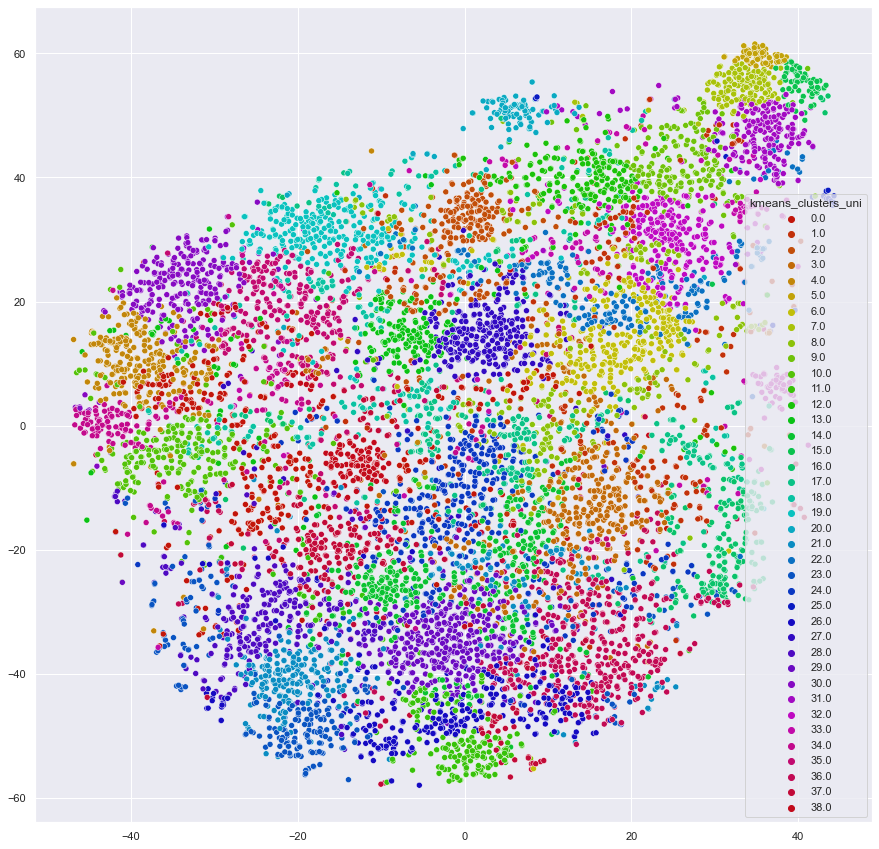

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(15,15)})

palette = sns.hls_palette(k, l=.4, s=.9)

sns.scatterplot(tsne_results[:,0], tsne_results[:,1], hue=df_combined.kmeans_clusters_uni.head(10000), palette=palette, legend='full')

In [90]:
# Check how successful the clustering was
y_labels = y_sub[:10000]
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_labels, y_pred))
print("Completeness: %0.3f" % metrics.completeness_score(y_labels, y_pred))
print("V-measure: %0.3f" % metrics.v_measure_score(y_labels, y_pred))

Homogeneity: 0.329
Completeness: 0.262
V-measure: 0.292


In [91]:
#Find nearest neighbours of a term
from scipy.spatial import distance
def findNearestNeighbour(term, vectors):
    term_vec = vectors[term]
    tmp = {k: v for k,v in sorted(vectors.items(), key=lambda item: distance.cosine(term_vec, item[1]))}
    nearest = list({k: tmp[k] for k in list(tmp)[:10]}.keys())

    return nearest



In [92]:
n = findNearestNeighbour('deep-neural-networks', vectors)
neighbourTerms = pd.DataFrame({n[0]:n[1:]})
n = findNearestNeighbour('computer-vision', vectors)
neighbourTerms[n[0]] = n[1:]
n = findNearestNeighbour('natural-language-processing', vectors)
neighbourTerms[n[0]] = n[1:]
n = findNearestNeighbour('algorithm', vectors)
neighbourTerms[n[0]] = n[1:]
n = findNearestNeighbour('machine-learning', vectors)
neighbourTerms[n[0]] = n[1:]

neighbourTerms

,deep-neural-networks,computer-vision,natural-language-processing,algorithm,machine-learning
0,dnns,natural-language-processing,nlp,method,deep-learning
1,dnn,nlp,computer-vision,algorithms,techniques
2,deep-learning,deep-learning,nlp-tasks,approach,tools
3,convolutional-neural-networks,image-processing,image-processing,iterative,approaches
4,neural-networks,machine-learning,biomedical,proposed,computer-vision
5,deep-learning-models,tasks,mathematics,optimal,machine-learning-models
6,architectures,applications,tasks,procedure,developed
7,machine-learning-models,recent-years,engineering,optimization,applications
8,cnns,image-classification,image-analysis,uses,frameworks


Silhouette Score for determining the best number of clusters

In [93]:
from sklearn.metrics import silhouette_samples, silhouette_score
range_n_clusters = [2, 5, 10, 15, 20, 25, 30, 35, 38, 40, 45]

def silhouette(range_n_clusters):
    for n_clusters in range_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(np_vectors)

        silhouette_avg = silhouette_score(np_vectors, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )
silhouette(range_n_clusters)

For n_clusters = 2 The average silhouette_score is : 0.18472516229331437
For n_clusters = 5 The average silhouette_score is : 0.10006044632847674
For n_clusters = 10 The average silhouette_score is : 0.06311157003394101
For n_clusters = 15 The average silhouette_score is : 0.05962607956374427
For n_clusters = 20 The average silhouette_score is : 0.05117379201925683
For n_clusters = 25 The average silhouette_score is : 0.05118158800879502
For n_clusters = 30 The average silhouette_score is : 0.050221921776679286
For n_clusters = 35 The average silhouette_score is : 0.050983211673584536
For n_clusters = 38 The average silhouette_score is : 0.047620685878898304
For n_clusters = 40 The average silhouette_score is : 0.04782840019072345
For n_clusters = 45 The average silhouette_score is : 0.04840632152807873


In [94]:
range_n_clusters = range(20,44,2)
silhouette(range_n_clusters)

For n_clusters = 20 The average silhouette_score is : 0.05117379201925683
For n_clusters = 22 The average silhouette_score is : 0.050663568444635244
For n_clusters = 24 The average silhouette_score is : 0.050683985722015774
For n_clusters = 26 The average silhouette_score is : 0.051105952139443155
For n_clusters = 28 The average silhouette_score is : 0.05024613998913728
For n_clusters = 30 The average silhouette_score is : 0.050221921776679286
For n_clusters = 32 The average silhouette_score is : 0.046764885886183584
For n_clusters = 34 The average silhouette_score is : 0.04999361682549239
For n_clusters = 36 The average silhouette_score is : 0.048637743716813446
For n_clusters = 38 The average silhouette_score is : 0.047620685878898304
For n_clusters = 40 The average silhouette_score is : 0.04782840019072345
For n_clusters = 42 The average silhouette_score is : 0.04959535618001115


In [95]:
range_n_clusters = range(36,40)
silhouette(range_n_clusters)

For n_clusters = 36 The average silhouette_score is : 0.048637743716813446
For n_clusters = 37 The average silhouette_score is : 0.05038266033542235
For n_clusters = 38 The average silhouette_score is : 0.047620685878898304
For n_clusters = 39 The average silhouette_score is : 0.047654441718043776


Elbow method for determining the best number of clusters

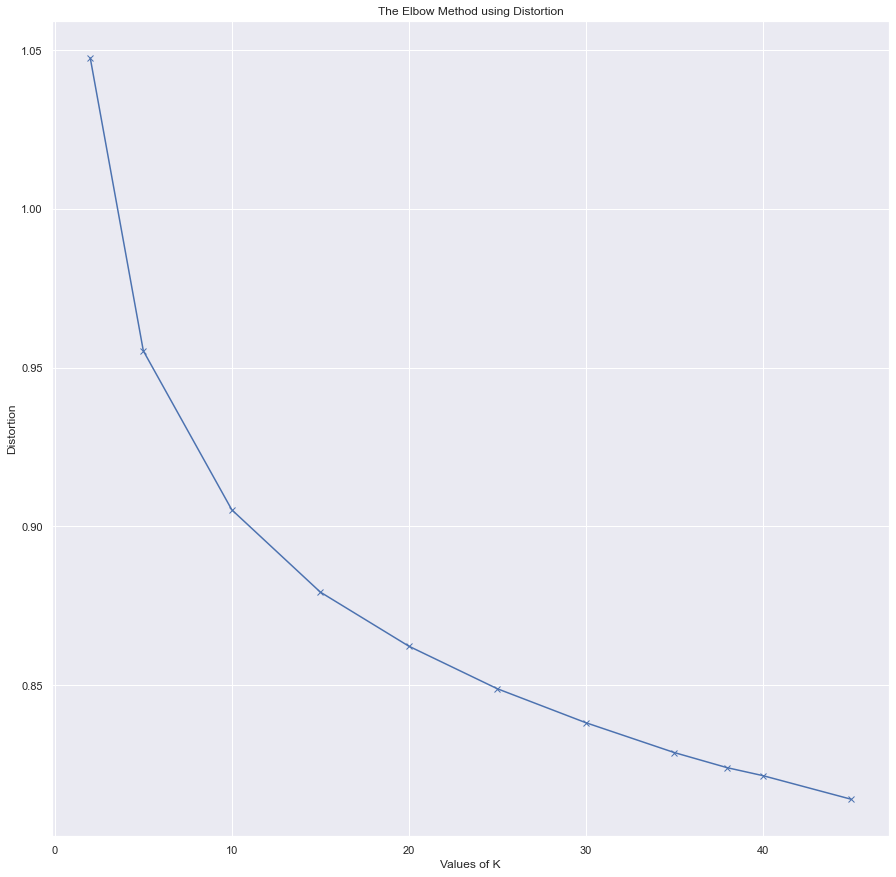

In [96]:
from sklearn import metrics
from scipy.spatial.distance import cdist

range_n_clusters = [2, 5, 10, 15, 20, 25, 30, 35, 38, 40, 45]

def elbow(range_n_clusters):
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}
    for n_clusters in range_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(np_vectors)

        distortions.append(sum(np.min(cdist(np_vectors, clusterer.cluster_centers_,
                                            'euclidean'), axis=1)) / len(np_vectors))
        inertias.append(clusterer.inertia_)
    
        mapping1[k] = sum(np.min(cdist(np_vectors, clusterer.cluster_centers_,
                                    'euclidean'), axis=1)) / len(np_vectors)
        mapping2[k] = clusterer.inertia_

    plt.plot(range_n_clusters, distortions, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method using Distortion')
    plt.show()

elbow(range_n_clusters)

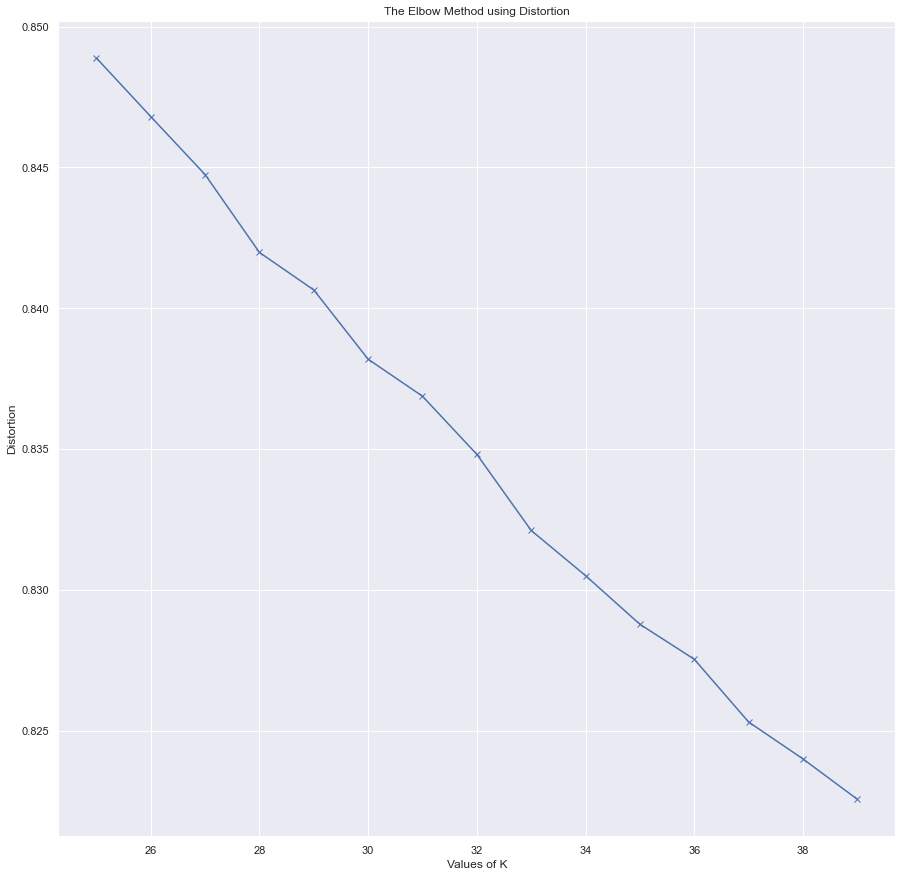

In [97]:
range_n_clusters = range(25, 40)
elbow(range_n_clusters)

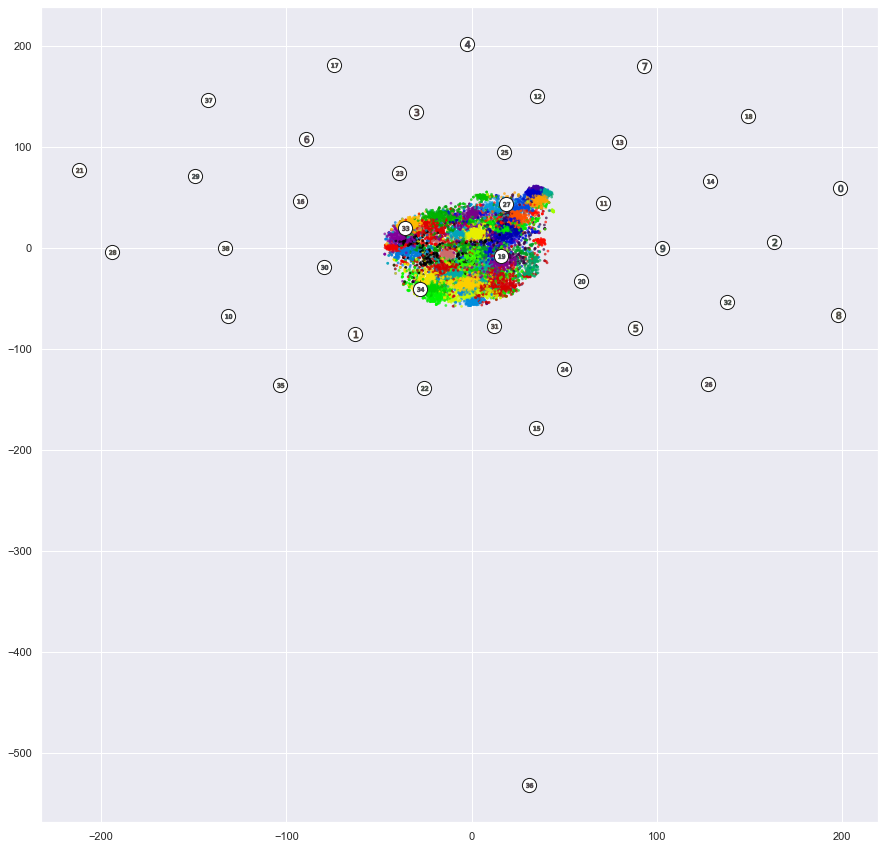

In [98]:
import matplotlib.cm as cm

clusterer = KMeans(n_clusters=k, random_state=42)
cluster_labels = clusterer.fit_predict(np_vectors)
#tsne_results = tsne.fit_transform(np_vectors)
fig, (ax1) = plt.subplots(1, 1)

colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
ax1.scatter(
        tsne_results[:, 0], tsne_results[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

# Labeling the clusters
centers = clusterer.cluster_centers_
tsne_centers = tsne.fit_transform(centers)
# Draw white circles at cluster centers
ax1.scatter(
    tsne_centers[:, 0],
    tsne_centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(tsne_centers):
    ax1.scatter(c[0], c[1], marker="$%d$" % i, alpha=0.7, s=50, edgecolor="k")

In [99]:
for center in centers:
    for k,v in vectors.items():
        if(v.all == center.all):
            print(k)

In [100]:
def findNearestNeighbourVec(term_vec, vectors):
    tmp = {k: v for k,v in sorted(vectors.items(), key=lambda item: distance.cosine(term_vec, item[1]))}
    nearest = list({k: tmp[k] for k in list(tmp)[:10]}.keys())

    return nearest

In [101]:
n = findNearestNeighbourVec(centers[0], vectors)
neighbourTerms2 = pd.DataFrame({n[0]:n[1:]})
for i in range(len(centers)):
    n = findNearestNeighbourVec(centers[i], vectors)
    print(i,n)
    neighbourTerms2[n[0]] = n[1:]

neighbourTerms2

0 ['use', 'addition', 'approach', 'work', 'present', 'techniques', 'used', 'both', 'framework', 'paper']
1 ['addition', 'approach', 'use', 'both', 'moreover', 'also', 'furthermore', 'proposed', 'which', 'present']
2 ['approach', 'design', 'proposed', 'addition', 'framework', 'both', 'based', 'present', 'system', 'control']
3 ['approach', 'proposed', 'addition', 'use', 'propose', 'method', 'methods', 'both', 'framework', 'based']
4 ['design', 'work', 'use', 'application', 'such', 'applications', 'research', 'paper', 'present', 'this']
5 ['d', 'k', 'n', 'p', '1', 'm', 'f', 'x', 'g', '2']
6 ['approach', 'method', 'proposed', 'addition', 'methods', 'use', 'algorithms', 'framework', 'present', 'both']
7 ['where', 'given', 'moreover', 'particular', 'n', '1', 'then', '2', 'prove', 'k']
8 ['addition', 'approach', 'proposed', 'both', 'use', 'method', 'present', 'based', 'using', 'also']
9 ['particular', 'also', 'moreover', 'addition', 'which', 'we', 'present', 'show', 'this', 'general']
10 ['us

,use,addition,approach,design,d,where,particular,graph,models,algorithm,moreover,present,data
0,addition,proposed,addition,applications,k,given,also,given,approach,approach,particular,use,use
1,task,use,propose,application,n,moreover,moreover,particular,addition,addition,given,addition,addition
2,tasks,approach,proposed,such,p,particular,addition,graphs,use,moreover,addition,particular,such
3,dataset,both,specifically,use,1,n,which,moreover,both,proposed,where,this,present
4,approach,specifically,use,addition,m,1,we,set,tasks,algorithms,which,approach,used
5,used,propose,based,systems,f,then,present,prove,proposed,present,furthermore,paper,work
6,datasets,methods,framework,present,x,2,show,where,framework,which,also,such,this
7,both,techniques,both,paper,g,prove,this,which,model,problem,algorithm,work,approach
8,present,used,network,work,2,k,general,then,our,method,show,new,as


In [102]:
findNearestNeighbour('graph', vectors)

['graph',
 'graphs',
 'directed',
 'structure',
 'node',
 'g',
 'edges',
 'network',
 'topology',
 'property']

In [103]:
print(len(set(y_pred)))

39


In [106]:
k = len(set(y_pred))

39

In [110]:
compare = {}
for i in range(k):
    compare[i] = []
for i in range(len(y_pred)):
    compare[y_pred[i]].append(y_sub[i])

for i in range(k):
    tmp = Counter(compare[i])
    compare[i] = dict(sorted(tmp.items(), key=lambda item: item[1], reverse=True))

compare


{0: {'cs.LG': 88,
  'cs.CV': 50,
  'cs.SE': 33,
  'cs.CL': 28,
  'cs.CY': 20,
  'cs.HC': 18,
  'cs.AI': 18,
  'cs.CR': 17,
  'cs.IR': 12,
  'cs.DL': 6,
  'cs.DB': 6,
  'cs.DC': 5,
  'cs.SI': 4,
  'cs.RO': 4,
  'cs.SY': 4,
  'cs.AR': 4,
  'cs.PL': 4,
  'cs.SD': 3,
  'cs.NA': 3,
  'cs.LO': 2,
  'cs.CE': 2,
  'cs.MS': 2,
  'cs.IT': 2,
  'cs.DS': 2,
  'cs.OH': 2,
  'cs.NE': 2,
  'cs.NI': 2,
  'cs.ET': 1,
  'cs.GT': 1,
  'cs.DM': 1,
  'cs.OS': 1,
  'cs.GR': 1},
 1: {'cs.LG': 122,
  'cs.IT': 21,
  'cs.NA': 21,
  'cs.CV': 18,
  'cs.NE': 7,
  'cs.SY': 6,
  'cs.DS': 5,
  'cs.CE': 5,
  'cs.CL': 4,
  'cs.AI': 3,
  'cs.DM': 2,
  'cs.DB': 2,
  'cs.CC': 2,
  'cs.GR': 2,
  'cs.CR': 2,
  'cs.GT': 1,
  'cs.MM': 1,
  'cs.IR': 1,
  'cs.LO': 1,
  'cs.SD': 1,
  'cs.CG': 1,
  'cs.MA': 1,
  'cs.DC': 1,
  'cs.OH': 1,
  'cs.SI': 1},
 2: {'cs.SY': 119,
  'cs.RO': 61,
  'cs.LG': 16,
  'cs.IT': 13,
  'cs.AI': 11,
  'cs.MA': 4,
  'cs.FL': 4,
  'cs.CR': 4,
  'cs.CE': 3,
  'cs.NA': 3,
  'cs.SI': 2,
  'cs.NI': 2,
  '

In [121]:
compare_main_cat = {}
for i in range(k):
    compare_main_cat[str(i)] = list(compare[i].items())[:1][0][0]
compare_main_cat
#print(set(compare_main_cat))
# {'cs.LG', 'cs.SI', 'cs.LO', 'cs.CR', 'cs.DM', 'cs.IT', 'cs.RO', 'cs.CV', 'cs.CL', 'cs.DC', 'cs.SE', 'cs.DS', 'cs.SY', 'cs.NA'}



{'0': 'cs.LG',
 '1': 'cs.LG',
 '2': 'cs.SY',
 '3': 'cs.LG',
 '4': 'cs.SE',
 '5': 'cs.DM',
 '6': 'cs.LG',
 '7': 'cs.DS',
 '8': 'cs.LG',
 '9': 'cs.NA',
 '10': 'cs.SI',
 '11': 'cs.CV',
 '12': 'cs.NA',
 '13': 'cs.RO',
 '14': 'cs.CV',
 '15': 'cs.DM',
 '16': 'cs.LG',
 '17': 'cs.LG',
 '18': 'cs.SY',
 '19': 'cs.IT',
 '20': 'cs.LG',
 '21': 'cs.CL',
 '22': 'cs.LG',
 '23': 'cs.CL',
 '24': 'cs.LG',
 '25': 'cs.IT',
 '26': 'cs.CV',
 '27': 'cs.LG',
 '28': 'cs.CL',
 '29': 'cs.CV',
 '30': 'cs.CR',
 '31': 'cs.DS',
 '32': 'cs.NA',
 '33': 'cs.LO',
 '34': 'cs.CR',
 '35': 'cs.DC',
 '36': 'cs.CV',
 '37': 'cs.CV',
 '38': 'cs.LG'}

In [125]:
cats = Counter(y_sub)
cats = dict(sorted(cats.items(), key=lambda item: item[1], reverse=True))
print(cats)
# {'cs.LG', 'cs.SI', 'cs.LO', 'cs.CR', 'cs.DM', 'cs.IT', 'cs.RO', 'cs.CV', 'cs.CL', 'cs.DC', 'cs.SE', 'cs.DS', 'cs.SY', 'cs.NA'}


{'cs.LG': 2168, 'cs.CV': 1811, 'cs.CL': 810, 'cs.NA': 475, 'cs.IT': 454, 'cs.RO': 386, 'cs.SY': 368, 'cs.CR': 360, 'cs.AI': 317, 'cs.DS': 226, 'cs.DC': 201, 'cs.SI': 200, 'cs.NI': 200, 'cs.CY': 189, 'cs.SE': 182, 'cs.HC': 172, 'cs.SD': 170, 'cs.IR': 148, 'cs.LO': 127, 'cs.GT': 119, 'cs.DM': 106, 'cs.NE': 98, 'cs.CE': 74, 'cs.CC': 73, 'cs.CG': 73, 'cs.DB': 72, 'cs.PL': 60, 'cs.MA': 57, 'cs.AR': 50, 'cs.ET': 47, 'cs.GR': 45, 'cs.DL': 40, 'cs.FL': 31, 'cs.MM': 28, 'cs.MS': 17, 'cs.OH': 15, 'cs.PF': 15, 'cs.SC': 12, 'cs.OS': 4}


KNN Classifier

In [148]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [150]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

def knn(neighbours, X, y):
    #Creating training and test splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    #Performing Feature Scaling
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    #Training KNN with k=5
    
    classifier = KNeighborsClassifier(n_neighbors=neighbours)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(classification_report(y_test, y_pred))

    plot_confusion_matrix(cm, set(y_sub), normalize=False)
    
    return y_pred


[[ 7  0  1 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0  2 ...  0  0  1]
 ...
 [ 1  0  0 ... 15  0  0]
 [ 0  0  0 ...  0 13  0]
 [ 5  0  0 ...  0  0 22]]
              precision    recall  f1-score   support

       cs.AI       0.17      0.11      0.13        64
       cs.AR       0.06      0.17      0.09         6
       cs.CC       0.17      0.14      0.15        14
       cs.CE       0.18      0.15      0.17        13
       cs.CG       0.00      0.00      0.00        12
       cs.CL       0.66      0.70      0.68       169
       cs.CR       0.41      0.51      0.45        72
       cs.CV       0.59      0.82      0.69       351
       cs.CY       0.19      0.23      0.21        31
       cs.DB       0.30      0.17      0.21        18
       cs.DC       0.24      0.22      0.23        37
       cs.DL       0.25      0.10      0.14        10
       cs.DM       0.36      0.25      0.30        16
       cs.DS       0.40      0.45      0.43        51
       cs.ET       0.33      0.08

/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


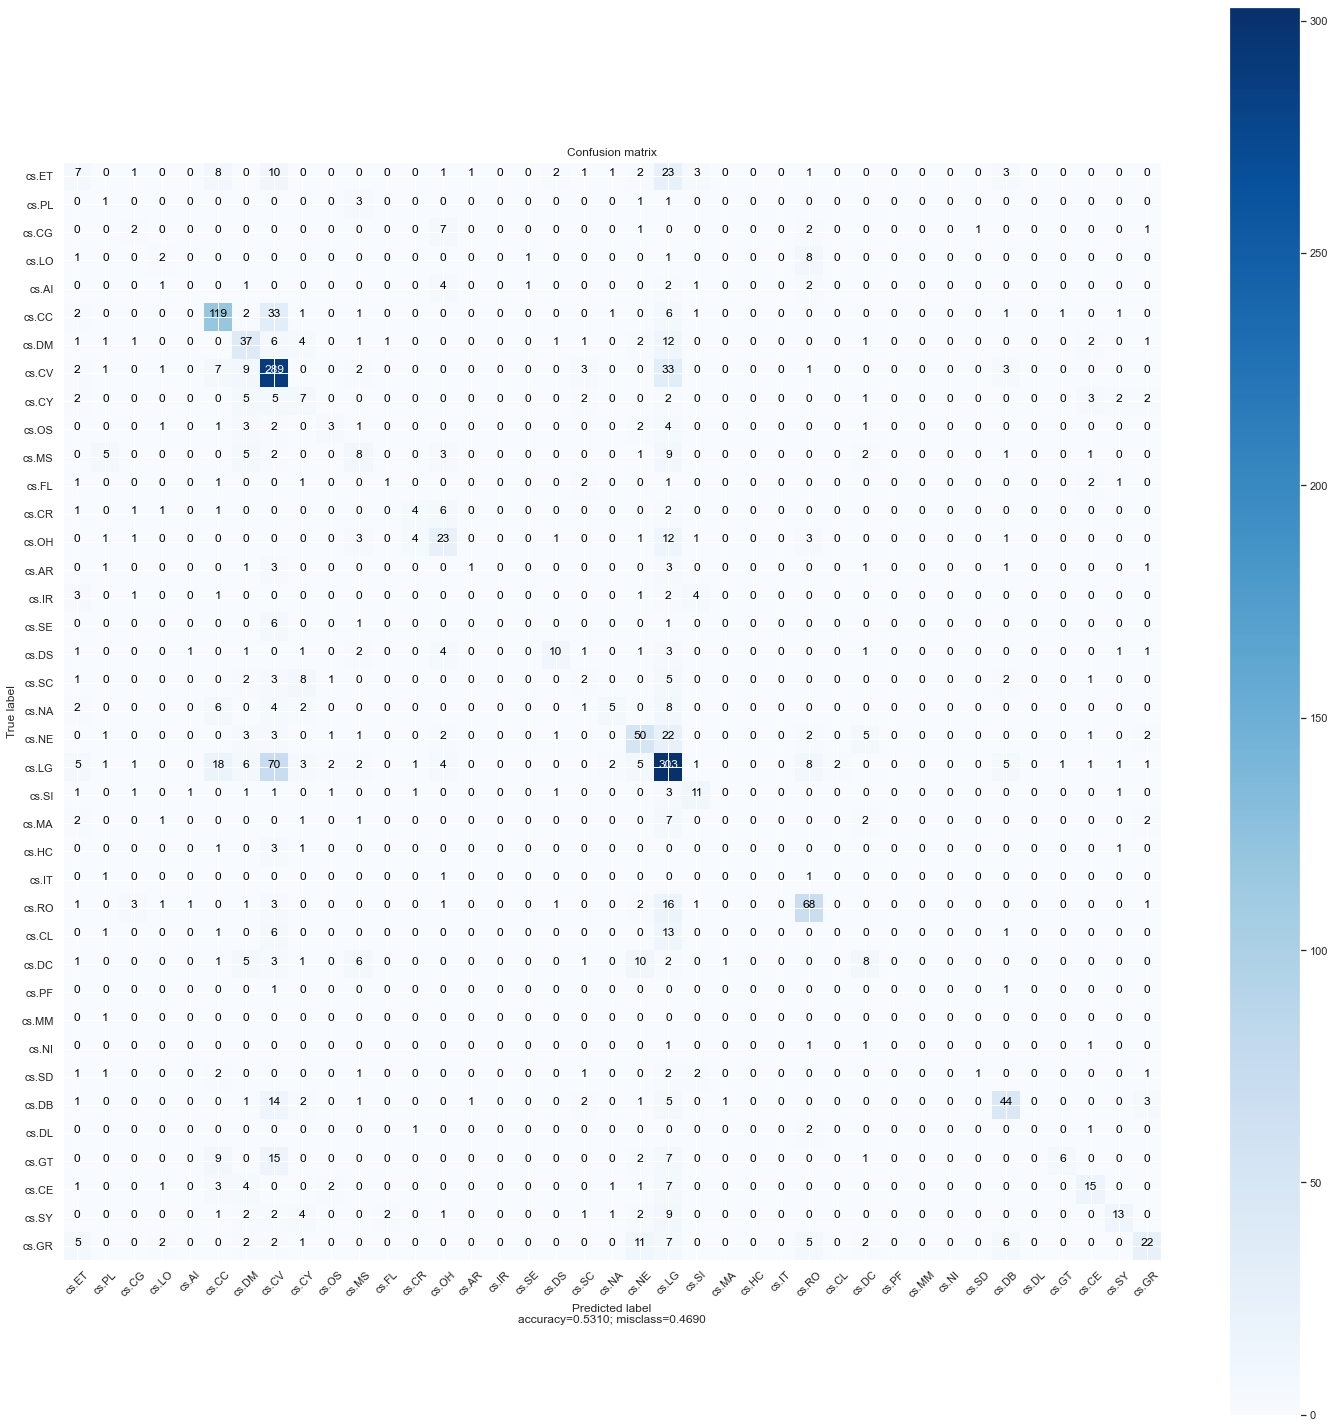

In [151]:
y_pred_knn = knn(9,np_vectors,y_sub)